# **MC-321 ML :** ASSIGNMENT 7
### **DHARMESH KOTA**
**202203038**

**Importing the necessary libraries**

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from ucimlrepo import fetch_ucirepo, list_available_datasets

# **Question 1: Classification**

Consider the CarEvaluation dataset (Available from: https://archive.ics.uci.edu/dataset/19/car+evaluation) and implement the following:
-  Grow the decision tree using the entropy measure (ID3 algorithm) or gini index (CART algorithm). Decision trees tend to be overly complex and do not generalize well to the data, leading to overfitting. To overcome this, use decision tree pruning to address overfitting. Prune the tree using cost complexity pruning (also known as weakest link pruning) and use cross-validation to find the optimal value of the complexity parameter
$α$. Plot the average accuracy vs. $α$. Visualize the pruned decision tree constructed on the training data.
- Use the inbuilt scikit-learn implementation for the above experiments.

In [ ]:
car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

print(car_evaluation.metadata.uci_id)
print(car_evaluation.metadata.num_instances)
print(car_evaluation.metadata.additional_info.summary)

print(car_evaluation.variables)

19
1728
Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:

CAR                      car acceptability
. PRICE                  overall price
. . buying               buying price
. . maint                price of the maintenance
. TECH                   technical characteristics
. . COMFORT              comfort
. . . doors              number of doors
. . . persons            capacity in terms of persons to carry
. . . lug_boot           the size of luggage boot
. . safety               estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a se

Unpruned Tree - Training Accuracy: 1.000, Test Accuracy: 0.985


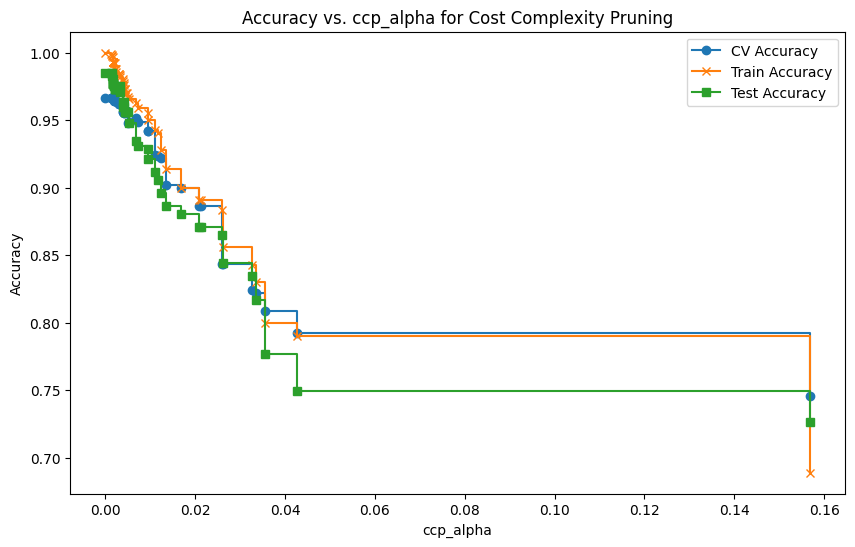

Optimal ccp_alpha based on CV: 0.00177
Pruned Tree - Training Accuracy: 0.993, Test Accuracy: 0.977


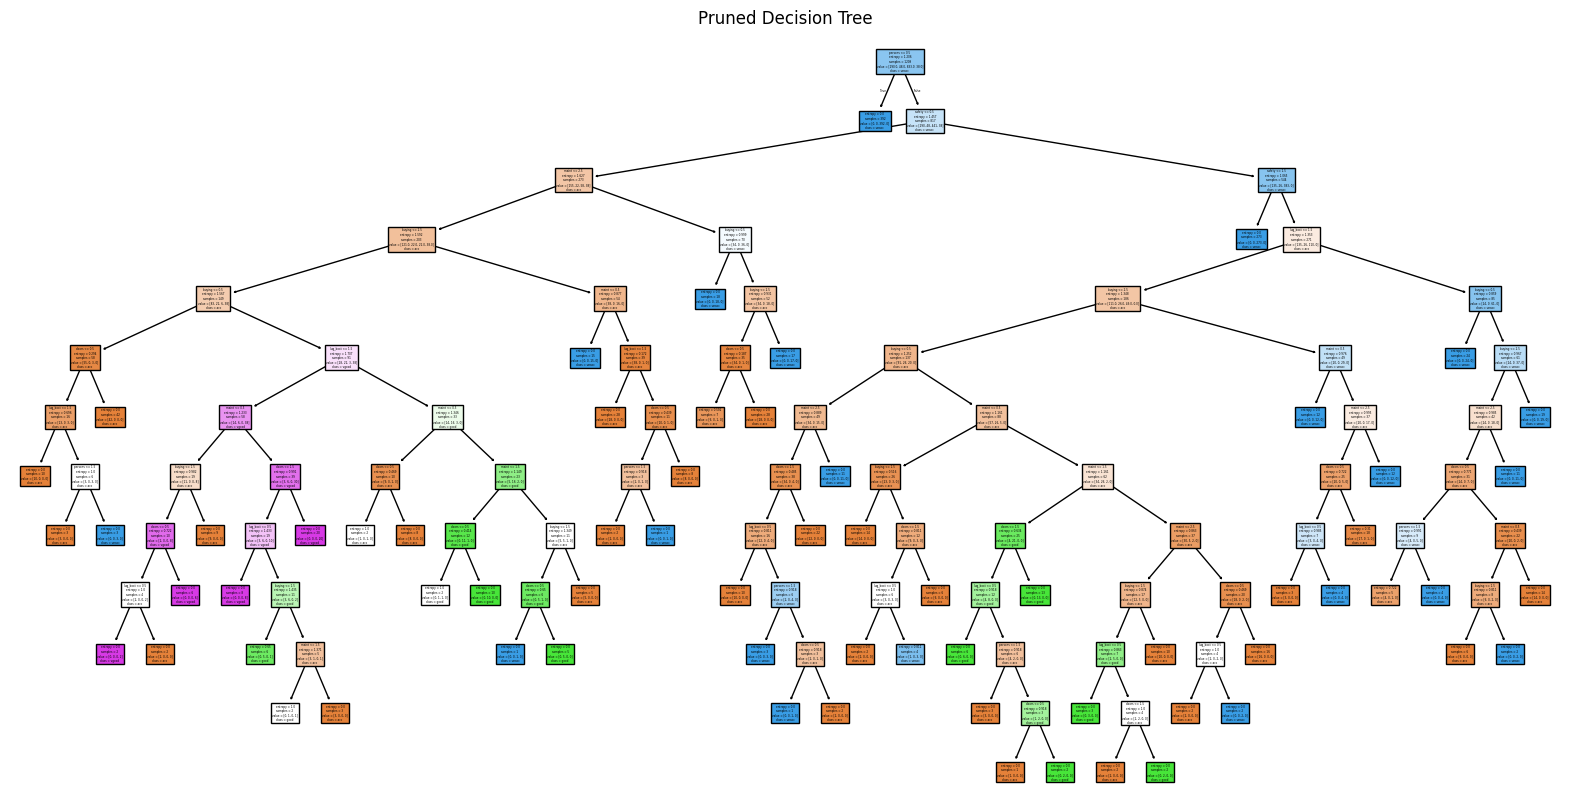

In [ ]:
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=[var for var in car_evaluation.variables['Variable Name']])

encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=38)


unpruned_tree = DecisionTreeClassifier(criterion='entropy', random_state=38)
unpruned_tree.fit(X_train, y_train)

train_acc_unpruned = unpruned_tree.score(X_train, y_train)
test_acc_unpruned = unpruned_tree.score(X_test, y_test)
print(f"Unpruned Tree - Training Accuracy: {train_acc_unpruned:.3f}, Test Accuracy: {test_acc_unpruned:.3f}")


path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
train_scores = []
test_scores = []
cv_scores = []
trees = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy', random_state=38, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)

    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

    cv_scores.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, cv_scores, marker='o', label="CV Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, train_scores, marker='x', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='s', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. ccp_alpha for Cost Complexity Pruning")
plt.legend()
plt.show()

optimal_alpha = ccp_alphas[np.argmax(cv_scores)]
print(f"Optimal ccp_alpha based on CV: {optimal_alpha:.5f}")


pruned_tree = DecisionTreeClassifier(criterion='entropy', random_state=38, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)
pruned_train_acc = pruned_tree.score(X_train, y_train)
pruned_test_acc = pruned_tree.score(X_test, y_test)
print(f"Pruned Tree - Training Accuracy: {pruned_train_acc:.3f}, Test Accuracy: {pruned_test_acc:.3f}")

plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, class_names=pruned_tree.classes_)
plt.title("Pruned Decision Tree")
plt.show()

# **Question 2: Regression**
On the Boston housing dataset (http://lib.stat.cmu.edu/datasets/boston), perform decision tree regression to predict the value of **MEDV**, representing the median price of owner-occupied homes.
- Grow the regression tree using recursive binary splitting. Decision trees tend to be overly complex and do not generalize well to the data, leading to overfitting. To overcome this, use decision tree pruning to address
overfitting. Prune the tree using cost complexity pruning and use cross-validation to find the optimal value of the complexity parameter α. Visualize the pruned decision tree constructed on the training data.
- Plot the regression curve for **MEDV** vs. **CRIM** (per capita crime rate by town), **MEDV** vs. **INDUS** (proportion of non-retail business acres per town), and **MEDV** vs. **AGE** (proportion of owner-occupied units built prior to 1940).
- Use the inbuilt scikit-learn implementation for the above experiments.

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

print(df.head())
print(df.info())
print(df.describe())

X = df.drop(columns=["medv"])
y = df["medv"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float6

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=38)

dt_reg.fit(X_train, y_train)

y_pred = dt_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Before Pruning): {mse:.4f}")

Mean Squared Error (Before Pruning): 9.9232


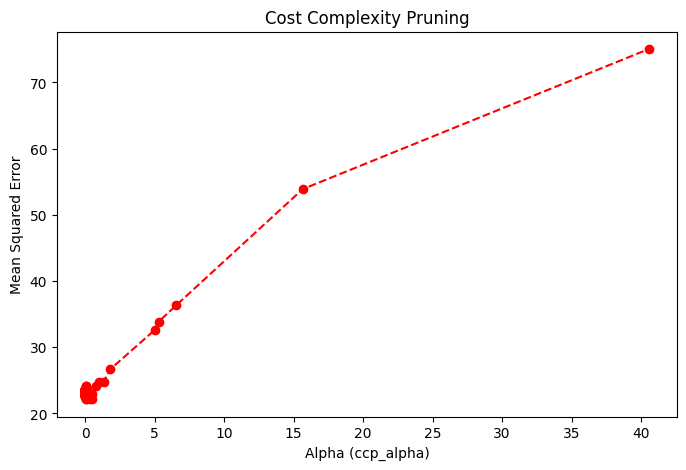

Optimal Alpha: 0.4814
Mean Squared Error (After Pruning): 12.6701


In [ ]:
path = dt_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

mse_scores = []

for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=38, ccp_alpha=alpha)
    scores = cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores.append(-np.mean(scores))

plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, mse_scores, color='red', marker='o', linestyle='--')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Mean Squared Error")
plt.title("Cost Complexity Pruning")
plt.show()

optimal_alpha = ccp_alphas[np.argmin(mse_scores)]
print(f"Optimal Alpha: {optimal_alpha:.4f}")

pruned_dt = DecisionTreeRegressor(random_state=38, ccp_alpha=optimal_alpha)
pruned_dt.fit(X_train, y_train)

y_pred_pruned = pruned_dt.predict(X_test)

mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Mean Squared Error (After Pruning): {mse_pruned:.4f}")

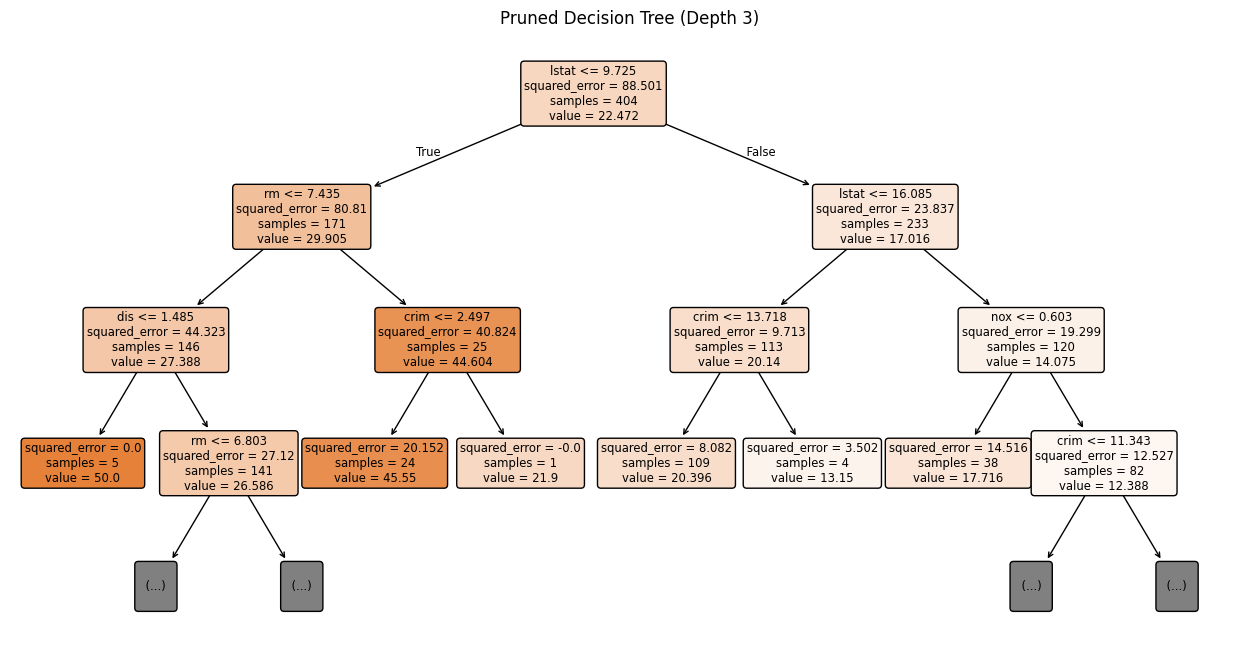

In [ ]:
plt.figure(figsize=(16, 8))
plot_tree(pruned_dt, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Pruned Decision Tree (Depth 3)")
plt.show()

In [ ]:
tree_rules = export_text(pruned_dt, feature_names=list(X.columns))
print(tree_rules)

|--- lstat <= 9.72
|   |--- rm <= 7.43
|   |   |--- dis <= 1.48
|   |   |   |--- value: [50.00]
|   |   |--- dis >  1.48
|   |   |   |--- rm <= 6.80
|   |   |   |   |--- rm <= 6.12
|   |   |   |   |   |--- value: [21.03]
|   |   |   |   |--- rm >  6.12
|   |   |   |   |   |--- value: [25.16]
|   |   |   |--- rm >  6.80
|   |   |   |   |--- value: [32.33]
|   |--- rm >  7.43
|   |   |--- crim <= 2.50
|   |   |   |--- value: [45.55]
|   |   |--- crim >  2.50
|   |   |   |--- value: [21.90]
|--- lstat >  9.72
|   |--- lstat <= 16.09
|   |   |--- crim <= 13.72
|   |   |   |--- value: [20.40]
|   |   |--- crim >  13.72
|   |   |   |--- value: [13.15]
|   |--- lstat >  16.09
|   |   |--- nox <= 0.60
|   |   |   |--- value: [17.72]
|   |   |--- nox >  0.60
|   |   |   |--- crim <= 11.34
|   |   |   |   |--- value: [14.08]
|   |   |   |--- crim >  11.34
|   |   |   |   |--- value: [9.45]



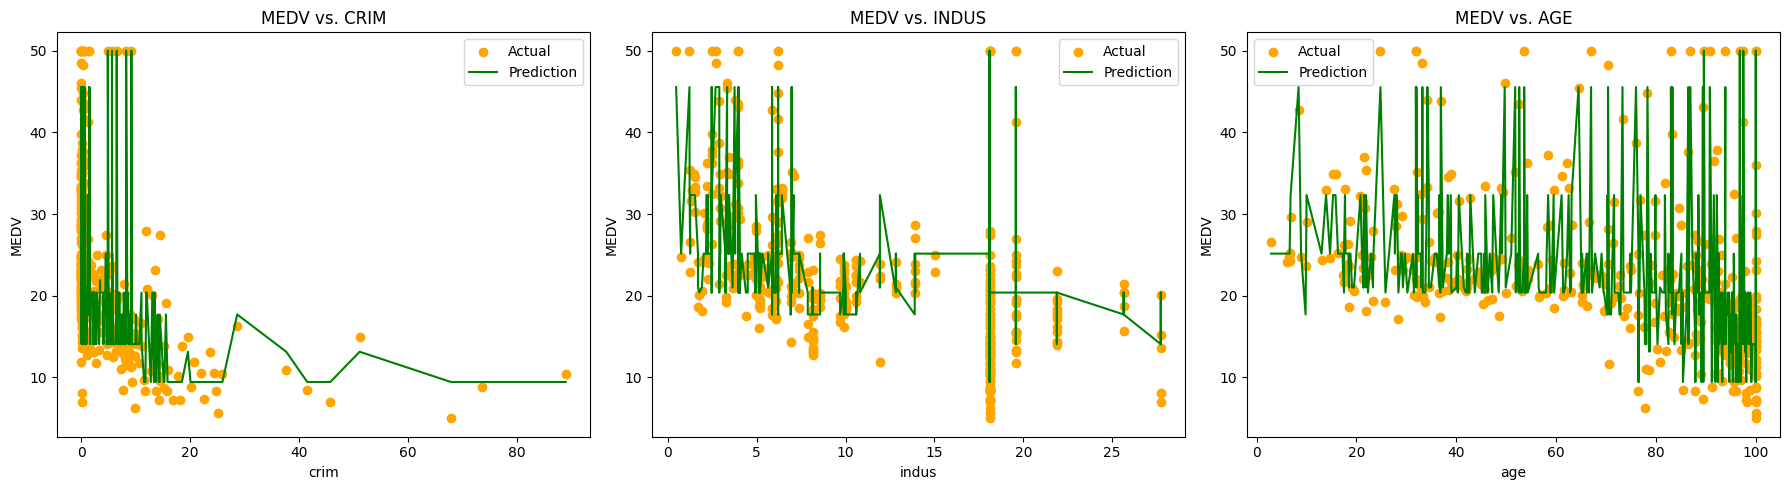

In [ ]:
def plot_regression_curve(feature, ax):
    sorted_idx = X_train[feature].argsort()
    sorted_feature = X_train[feature].iloc[sorted_idx]
    sorted_pred = pruned_dt.predict(X_train.iloc[sorted_idx])

    ax.scatter(X_train[feature], y_train, color='orange', label='Actual')
    ax.plot(sorted_feature, sorted_pred, color='green', label='Prediction')
    ax.set_xlabel(feature)
    ax.set_ylabel("MEDV")
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_regression_curve("crim", axes[0])
axes[0].set_title("MEDV vs. CRIM")

plot_regression_curve("indus", axes[1])
axes[1].set_title("MEDV vs. INDUS")

plot_regression_curve("age", axes[2])
axes[2].set_title("MEDV vs. AGE")

plt.tight_layout()
plt.show()